# Importing the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize, rescale, rotate

Making an image using numpy and padding the image

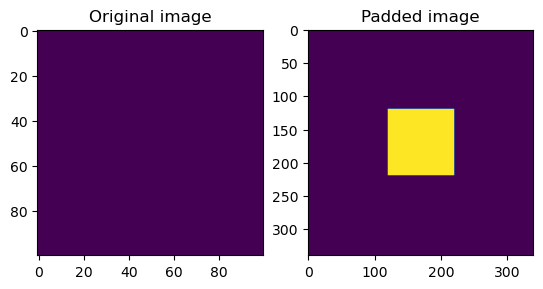

In [2]:
image = np.ones ([100,100]) #make a 100x100 square of ones
fig , (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image)
ax1.set_title('Original image')
diagonal= max(image.shape)+10
image = np.pad(image,pad_width = diagonal+10 ,mode='constant',constant_values=0)
ax2.imshow(image)
ax2.set_title('Padded image')
plt.show()

Creating the artificial tumor

Explaination for the linspace and meshgrids : By looking at the corresponding values in xv and yv for a specific point, you can pinpoint the exact location of that pixel on the image sheet.
For example, if xv[20, 30] is 0.5 and yv[20, 30] is 0.8, it means the pixel at row 20, column 30 in the image has an x-coordinate of 0.5 and a y-coordinate of 0.8 (these specific values depend on the normalization used in linspace).

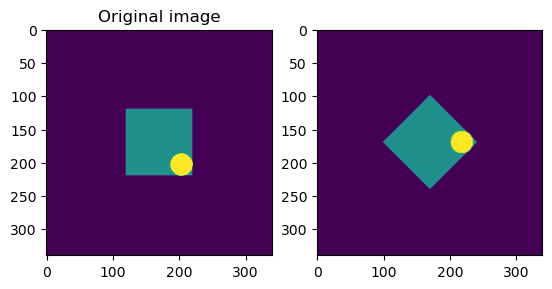

In [3]:
_ = np.linspace(-1,1,image.shape[0])
xv , yv = np.meshgrid(_,_)
image[(xv-0.2)**2+(yv-0.2)**2<0.01]= 2 # making the intensity of the tumor = 2 
image_rot = rotate(image,angle=45)
fig , (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image)
ax1.set_title('Original image')
ax2.imshow(image_rot)

Creating a sinogram for the above image

In [4]:
def sinogram(image,thetas):
    rs = np.linspace(-1,1,image.shape[0])
    dtheta = np.diff(thetas)[0]
    rotations = np.array([rotate(image,theta*180/np.pi) for theta in thetas])
    dr = np.diff(rs)[0] # as the values are taken in a discrete manner we multiply by step size for normalization
    p = np.array([rotation.sum(axis=0)*dr for rotation in rotations]).T
    return rotations , p
    

Text(0, 0.5, 'intensity')

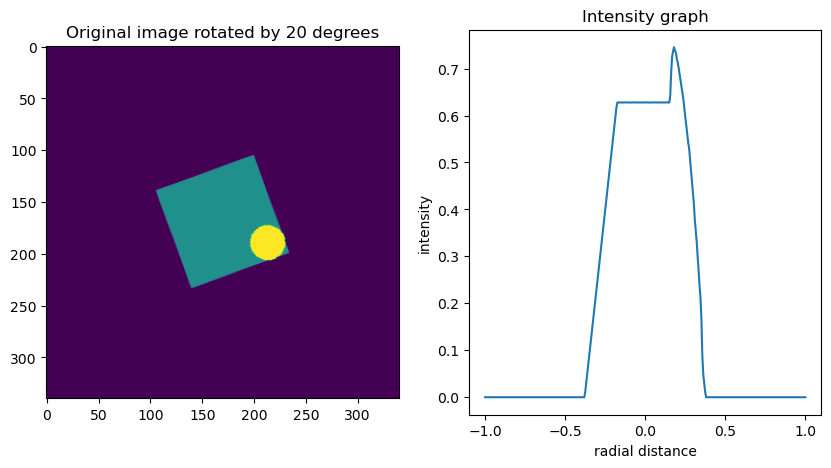

In [5]:
rs = _
thetas = np.arange (0,180,0.5)*np.pi/180
rotations , p = sinogram(image, thetas)
fig , ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rotations[40])
ax[0].set_title('Original image rotated by 20 degrees')
ax[1].plot(rs,p[:,40])
ax[1].set_title('Intensity graph')
ax[1].set_xlabel("radial distance")
ax[1].set_ylabel('intensity')

Text(0.5, 1.0, 'Sinorogram graph')

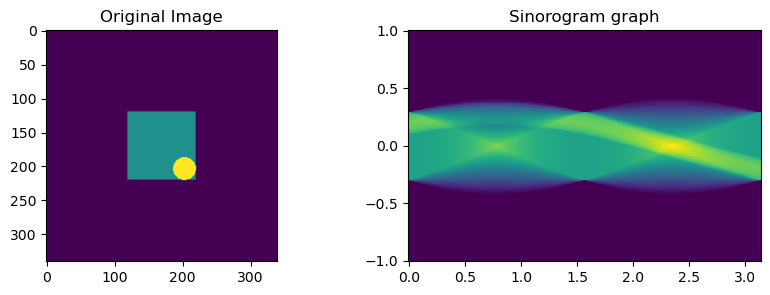

In [6]:
fig , ax = plt.subplots(1,2,figsize=(10,3))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].pcolor(thetas,rs,p,shading="auto")
ax[1].set_title('Sinorogram graph')

### Trying with the original image of thr brain

Text(0.5, 1.0, 'Original Image')

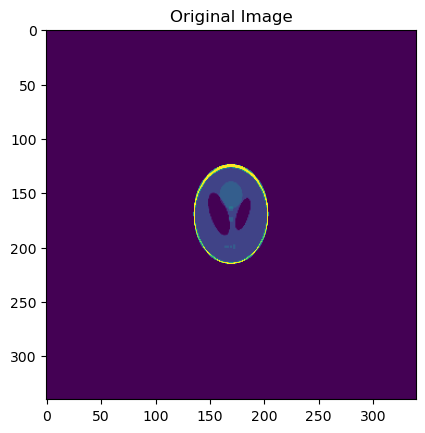

In [7]:
phantom = cv2.imread("shepp_logan_phantom.png")
phantom = cv2.cvtColor(phantom, cv2.COLOR_RGB2GRAY)
phantom = cv2.resize(phantom,(100,100))
diagonal= max(phantom.shape)+10
phantom = np.pad(phantom,pad_width = diagonal+10 ,mode='constant',constant_values=0)

plt.imshow(phantom)
plt.title("Original Image")


Text(0, 0.5, 'Radial Distance')

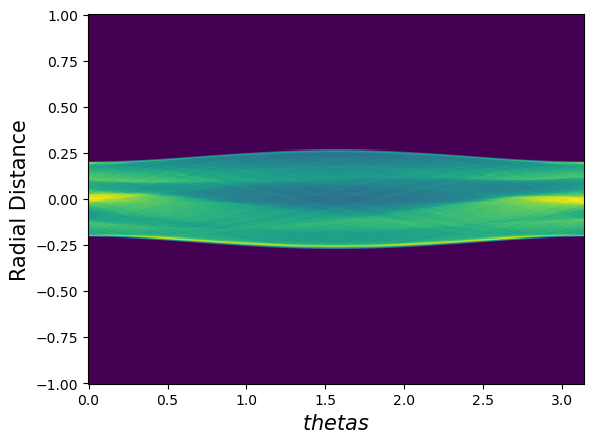

In [8]:
rs = _
thetas = np.arange (0,180,0.5)*np.pi/180
dtheta = np.diff(thetas)[0]# diff between the 2 angles in radians 
rotations , p = sinogram(phantom, thetas)
plt.pcolor(thetas,rs,p,shading="auto")
plt.xlabel(r"$thetas$",fontsize = 15)
plt.ylabel(r"Radial Distance",fontsize = 15)

## BackProjection

Here the RecBivariate acts as a function that uses interpolation to get the unknown values , ie for all set of radial distance and thetas
np.vectorize function makes sure that the function is calculated for all possible combinations for all xv, yv 

x cos(theta) + y sin(theta) calculates the intensity along the direction of the ray (normal to the direction of the plane from where the beams are shot

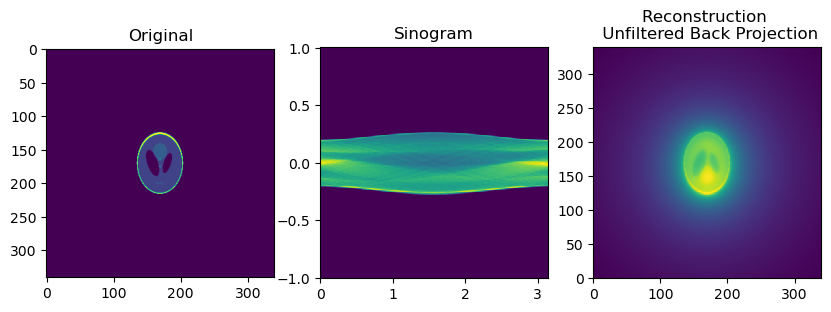

In [9]:
from scipy.interpolate import RectBivariateSpline
p_interp = RectBivariateSpline(rs, thetas,
                               p)  #used to interpolate the data for the points whose exact values are not mentioned, for instance the projection function p is not calculated for all values of rs and theta so RectBivariateSpline function is used to find the values for the missing points
def get_fBP(x, y):
    return p_interp(x * np.cos(thetas) + y * np.sin(thetas), thetas, grid=False).sum() * dtheta


fBP = np.vectorize(get_fBP)(xv, yv)
fig , ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(phantom)
ax[0].set_title("Original")
ax[1].set_title("Sinogram")
ax[1].pcolor(thetas,rs,p,shading='auto')
ax[2].set_title("Reconstruction \n Unfiltered Back Projection")
ax[2].pcolor(fBP)


# Using Fast Fourier Transform

It takes the sinogram data, which represents intensity measurements at different angles, and transforms it into the frequency domain using FFT. There, a filter is applied to the data, potentially emphasizing certain frequencies or suppressing noise. Finally, the data is transformed back to the spatial domain using the inverse FFT. This filtered data is then used for backprojection, a technique that essentially sums intensity values along rays to reconstruct the image. By incorporating filtering, this step aims to improve the quality of the reconstructed image by reducing noise and enhancing desired features.

In [10]:
from scipy.fft import fft, ifft

thetas = np.arange (0,180,0.5)*np.pi/180
dtheta = np.diff(thetas)[0]# diff between the 2 angles in radians 
P = fft(p, axis=0) #This transforms the sinogram from the spatial domain (intensity variations) to the frequency domain (frequency components).
nu = np.fft.fftfreq(P.shape[0], d=np.diff(rs)[0])#Calculates the frequencies associated with each element in the FFT result


integrand = P.T * np.abs(nu)
integrand = integrand.T
p_p = np.real(ifft(integrand, axis=0))#Performs an inverse FFT on integrand along axis 0. This transforms the filtered data back from the frequency domain to the spatial domain.
p_p_interp = RectBivariateSpline(rs, thetas, p_p)




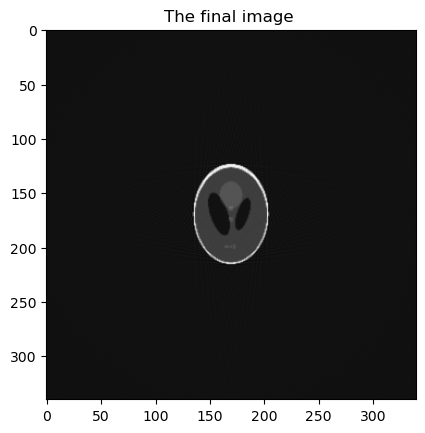

In [11]:
def get_f(x, y):
    return p_p_interp(x * np.cos(thetas) + y * np.sin(thetas), thetas, grid=False).sum() * dtheta


f = np.vectorize(get_f)(xv, yv)
plt.title("The final image ")
plt.imshow(f,cmap='gray')


# Using Different filters 

This section incorporates filters to improve the reconstruction quality. We take the sinogram data, which represents intensity measurements at different angles, and transform it into the frequency domain using FFT. Here, various filters can be applied to emphasize specific features or suppress noise.

For instance, the Ramp filter strengthens high frequencies, enhancing edges but potentially increasing noise. The Shepp-Logan filter, specifically designed for CT, offers a good balance between noise reduction and edge preservation. Other options include the Cosine filter for smoother reconstructions (but potentially blurred edges), and the Hamming/Hann filters that provide a balance between noise suppression and edge sharpness. By choosing an appropriate filter, we can significantly influence the final image quality.

In [15]:
from scipy.fft import fft, fftfreq, fftshift
from numpy.fft import ifftshift
def fourier_filters(size , filter_name):
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                        np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    fourier_filter = 2 * np.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]


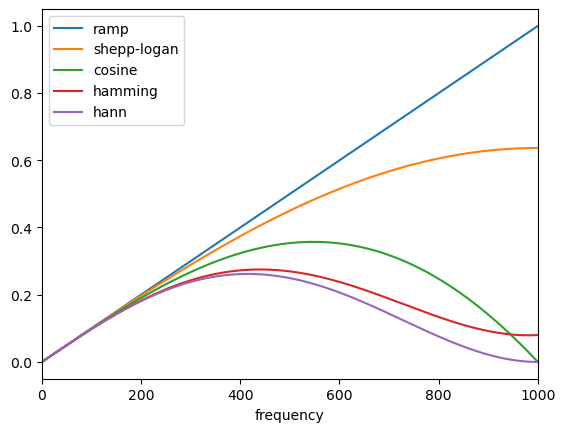

In [16]:

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

for ix, f in enumerate(filters):
    response = fourier_filters(2000, f)
    plt.plot(response, label=f)

plt.xlim([0, 1000])
plt.xlabel('frequency')
plt.legend()
plt.show()

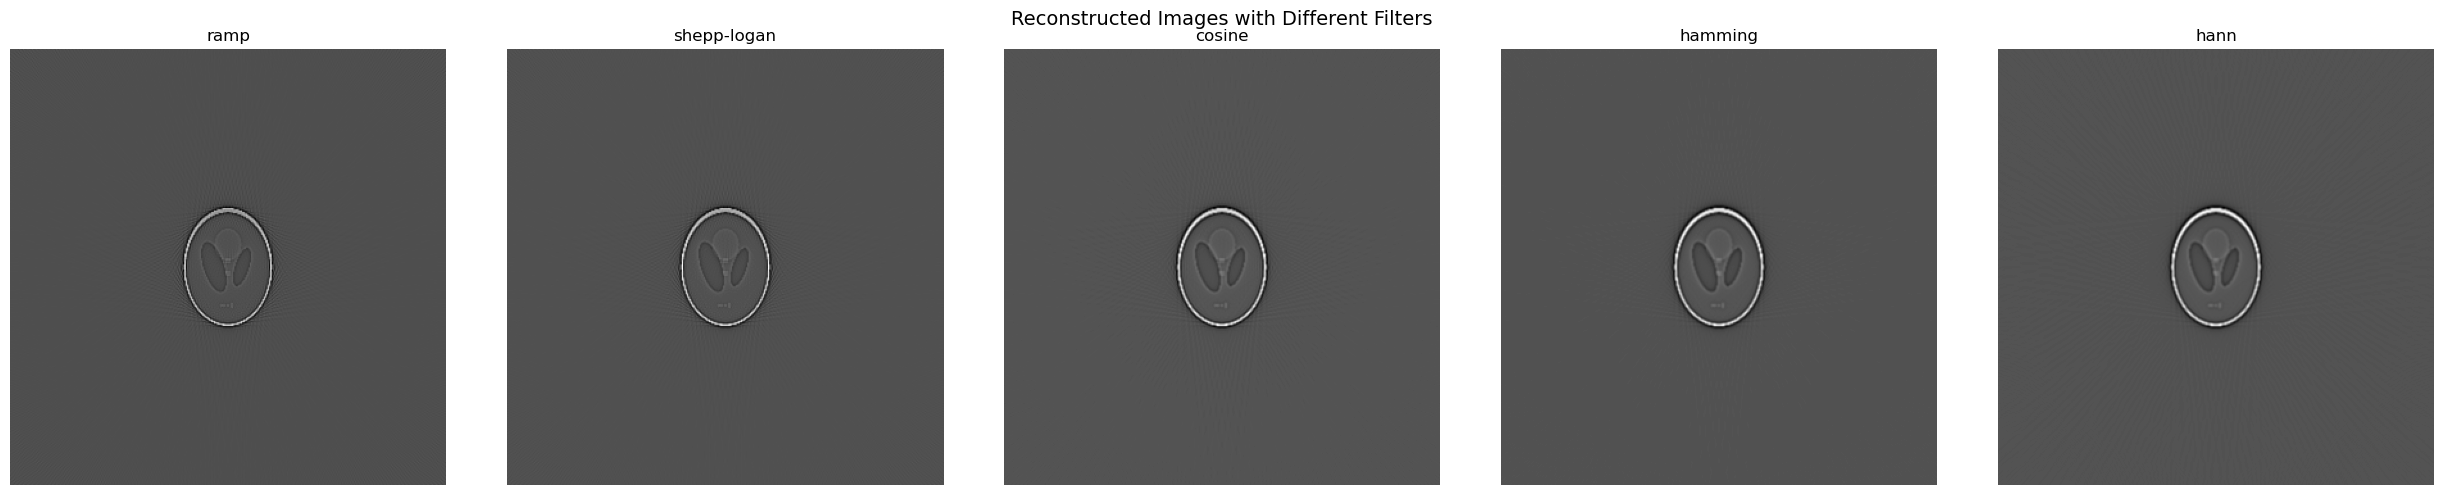

In [17]:
fig, axes = plt.subplots(1, len(filters) , figsize=(25,5)) 

for ix, filter_name in enumerate(filters):
    fourier_filter = fourier_filters(phantom.shape[0], filter_name)
    thetas = np.arange(0, 180, 0.5) * np.pi / 180
    dtheta = np.diff(thetas)[0]  # diff between the 2 angles in radians 
    P = fft(p, axis=0)*fourier_filter
    nu = np.fft.fftfreq(P.shape[0], d=np.diff(rs)[0])

    integrand = P.T * np.abs(nu)
    integrand = integrand.T
    p_p = np.real(ifft(integrand, axis=0))
    p_p_interp = RectBivariateSpline(rs, thetas, p_p)

    def get_f(x, y):
        return p_p_interp(x * np.cos(thetas) + y * np.sin(thetas), thetas, grid=False).sum() * dtheta


    f = np.vectorize(get_f)(xv, yv)

    # Display the reconstructed image in the current subplot
    axes.flat[ix].imshow(f, cmap='gray')  # Assuming axes is a flat array
    axes.flat[ix].set_title(filter_name)
    axes.flat[ix].axis('off')  # Remove unnecessary axes

# Common labels outside the loop (optional)
fig.suptitle('Reconstructed Images with Different Filters', fontsize=14)
plt.tight_layout()  # Adjust spacing between subplots

plt.show()